In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#sns.set_context("notebook", font_scale=1.5)
!pip install tqdm
import tqdm

Downloading/unpacking tqdm
Cleaning up...


In [75]:
#!cat /project/python/lib/trading/simulator.py

In [2]:
class Example():
    
    def __init__(self, param1, param2, param3):
        """Example of docstring on the __init__ method.

        The __init__ method may be documented in either the class level
        docstring, or as a docstring on the __init__ method itself.

        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            param1 (str): Description of `param1`.
            param2 (Optional[int]): Description of `param2`. Multiple
                lines are supported.
            param3 (List[str]): Description of `param3`.

        """
    
    
    def foo():
        """Example of docstring on the __init__ method.

        The __init__ method may be documented in either the class level
        docstring, or as a docstring on the __init__ method itself.

        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            param1 (str): Description of `param1`.
            param2 (Optional[int]): Description of `param2`. Multiple
                lines are supported.
            param3 (List[str]): Description of `param3`.

        """
        
    def foo2():
        """Class methods are similar to regular functions.
        
        Args:
            param1: The first parameter.
            param2: The second parameter.

        Returns:
            True if successful, False otherwise.

        """

In [3]:
def foo(*args,**kwargs):
    """Simple training function to do miracles"""
    print("~~~ARGS:")
    for value in args:
        print("{0} ({1})".format(value,type(value)))
    print("\n~~~KWARGS:")
    for item,value in kwargs.items():
        print("{0} - {1} ({2})".format(item,value,type(value)))
foo("hehe",dude=1,ok="hehe") 
foo(*["arg1","arg2"],**{"that":"thing","is":"funny"})

~~~ARGS:
hehe (<type 'str'>)

~~~KWARGS:
ok - hehe (<type 'str'>)
dude - 1 (<type 'int'>)
~~~ARGS:
arg1 (<type 'str'>)
arg2 (<type 'str'>)

~~~KWARGS:
is - funny (<type 'str'>)
that - thing (<type 'str'>)


In [7]:
import logging

import numpy as np
import pandas as pd


from trading.report import Entry, Win, Lose, Draw, Trade, Trades
from trading.market import pips2price, Pips, get_price_with_spread

logger = logging.getLogger(__name__)


class Position(object):

    def __init__(self, timestamp, entry_price, symbol, side, volume=1):
        assert side in ("long", "short")
        self.symbol = symbol
        self.is_long = side == "long"
        self.volume = volume
        self.enter(timestamp, entry_price, side)

    def enter(self, time, price, side):
        self._pips_price_ratio = 1. / Pips.get(self.symbol)
        self.entry = Entry(time=time, price=price, score=None, side=side)
        self.current = self.entry.price

    def update(self, price):
        self.current = price

    def profit(self, price=None):
        if price is None:
            price = self.current

        if self.is_long:
            return self.volume * (price - self.entry.price)
        else:
            return self.volume * (self.entry.price - price)

    def profit_pips(self, price=None):
        return self.profit() * self._pips_price_ratio


class Account(object):

    def __init__(self, balance, df):
        # balance is in pips
        self.balance = balance
        self.position = None
        dflen = len(df)
        history = df.copy()
        self.history = history
        self.hist_balance = np.zeros(dflen)
        self.hist_position_profit = np.zeros(dflen)
        self.hist_entry = []  # timestamp when position was entered
        self.hist_exit = []  # timestamp when position was exited
        self.trades = Trades()

    def has_position(self):
        return self.position is not None

    def total_balance(self):
        total = self.balance
        if self.has_position():
            total += self.position.profit_pips()
        return total

    def enter_position(self, timestamp, time_iloc, price, symbol, side):
        self.position = Position(timestamp, price, symbol, side)
        self.hist_entry.append(timestamp)

    def check_exit(self, current_price, entry_price, timestamp, pt, lc):
        # pt/lc in price
        exit = None
        if self.position.is_long:
            if current_price >= entry_price + pt:
                gain = current_price - entry_price
                exit = Win(time=timestamp, price=current_price, gain=gain)
            elif current_price <= entry_price - lc:
                gain = current_price - entry_price
                exit = Lose(time=timestamp, price=current_price, gain=gain)
        else:
            if current_price <= entry_price - pt:
                gain = entry_price - current_price
                exit = Win(time=timestamp, price=current_price, gain=gain)
            elif current_price >= entry_price + lc:
                gain = entry_price - current_price
                exit = Lose(time=timestamp, price=current_price, gain=gain)
        if exit is not None:
            self.balance += self.position._pips_price_ratio * exit.gain
            self.trades.append(Trade(entry=self.position.entry, exit=exit))
            self.hist_exit.append(exit.time)
            self.position = None
            return exit

    def check_exit_by_time(self, entry_price, exit_price, timestamp, ts_exit):
        exit = None
        if timestamp >= ts_exit:
            if self.position.is_long:
                if exit_price >= entry_price:
                    gain = exit_price - entry_price
                    exit = Win(time=timestamp, price=exit_price, gain=gain)
                elif exit_price <= entry_price:
                    gain = exit_price - entry_price
                    exit = Lose(time=timestamp, price=exit_price, gain=gain)
            else:
                if exit_price <= entry_price:
                    gain = entry_price - exit_price
                    exit = Win(time=timestamp, price=exit_price, gain=gain)
                elif exit_price >= entry_price:
                    gain = entry_price - exit_price
                    exit = Lose(time=timestamp, price=exit_price, gain=gain)
        if exit is not None:
            self.balance += self.position._pips_price_ratio * exit.gain
            self.trades.append(Trade(entry=self.position.entry, exit=exit))
            self.hist_exit.append(exit.time)
            self.position = None
            return exit

    def close_draw(self, timestamp):
        if self.position is not None:
            position = self.position
            exit = Draw(
                time=timestamp,
                price=position.current,
                gain=position.entry.price -
                position.current)
            trade = Trade(entry=position.entry, exit=exit)
            self.trades.append(trade)
            self.position = None

    @property
    def minute_total(self):
        return pd.Series(
            self.hist_balance +
            self.hist_position_profit,
            index=self.history.index)

    @property
    def daily_total(self):
        mt = self.minute_total
        if mt.shape == (0, ):
            return pd.DataFrame(
                [], index=[], columns=('open', 'high', 'low', 'close'))
        else:
            df = mt.resample('1D', how='ohlc')
            return df[pd.notnull(df.open)]

    @property
    def monthly_total(self):
        mt = self.minute_total
        if mt.shape == (0, ):
            return pd.DataFrame(
                [], index=[], columns=('open', 'high', 'low', 'close'))
        else:
            df = mt.resample('1M', how='ohlc')
            return df[pd.notnull(df.open)]


def get_trade_entry_timestamps(scores, threshold):
    '''
    Returns a list of timestamps representing entry points.
    '''
    entry_timestamps = []
    in_entry = False
    for i in xrange(len(scores) - 1):
        score = scores['confidence'].values[i]
        if score >= threshold:
            if not in_entry:
                entry_timestamps.append(scores.index[i + 1])
            in_entry = True
        else:
            in_entry = False
    return entry_timestamps


def calc(df, entry_timestamps, symbol, side, pt, lc):

    # pt/lc in pips
    pt_val, lc_val = (pips2price(pt, symbol), pips2price(lc, symbol))

    account = Account(0, df)

    if len(entry_timestamps) == 0:
        return account

    open = df['open'].values
    close = df['close'].values
    tstamp = np.ndarray(
        (len(df),), dtype='datetime64[ns]', buffer=df.index.data)

    previous_time_iloc = 0
    for timestamp in entry_timestamps:
        # This is intentionally not a get_loc because of potential gaps in the
        # index
        time_iloc = df.index.searchsorted(timestamp)
        if time_iloc <= previous_time_iloc:
            continue  # We can't enter during previous positions
        # log account balance between positions
        account.hist_balance[previous_time_iloc:time_iloc] = account.balance
        # enter the position
        entry_price = get_price_with_spread(
            open[time_iloc], symbol, 'Ask' if side == 'long' else 'Bid')
        account.enter_position(
            tstamp[time_iloc],
            time_iloc,
            entry_price,
            symbol,
            side)

        pips_price_ratio = account.position._pips_price_ratio
        volume = account.position.volume
        entry_balance = account.balance
        exit = None
        while exit is None and time_iloc < len(open):
            current_price = get_price_with_spread(
                close[time_iloc], symbol, 'Bid' if side == 'long' else 'Ask')
            account.position.current = current_price  # record current price
            exit = account.check_exit(
                current_price,
                entry_price,
                tstamp[time_iloc],
                pt_val,
                lc_val)
            if exit is None:
                position_profit = volume * \
                    (current_price - entry_price) * pips_price_ratio
                if not account.position.is_long:
                    position_profit *= -1
                account.hist_balance[time_iloc] = entry_balance
            else:
                position_profit = 0.
                account.hist_balance[time_iloc] = account.balance

            account.hist_position_profit[time_iloc] = position_profit
            time_iloc += 1
        previous_time_iloc = time_iloc  # start of timeframe not in position

    # log account balance to the end of the timeframe
    account.hist_balance[time_iloc:] = account.balance
    account.close_draw(timestamp)
    return account


def calc_by_positions(df, positions, symbol, side):
    """
        It calculates historical balance by pre-defined positions which was
        executed by the live testing. Since the live trading runs at best
        effort basis with 1s interval by using xignite's realtime rate api,
        so there are potential gaps between the historical data. To match
        the balance, it respects timing and price of executed positions and
        just interpolates balance during the position by using the historical
        data.

    Args:
        df (DataFrame): ohlc
        positions List((datetime, float), (datetime, float)): positions
        symbol (str): symbol
        side (str): side

    Returns:
        Account: Account object
    """

    account = Account(0, df)

    open = df['open'].values
    close = df['close'].values
    tstamp = np.ndarray(
        (len(df),), dtype='datetime64[ns]', buffer=df.index.data)

    time_iloc = previous_time_iloc = 0
    for (entry_ts, entry_price), (exit_ts, exit_price) in positions:
        # This is intentionally not a get_loc because of potential gaps in the
        # index
        time_iloc = df.index.searchsorted(entry_ts)
        if time_iloc <= previous_time_iloc:
            continue  # We can't enter during previous positions
        # log account balance between positions
        account.hist_balance[previous_time_iloc:time_iloc] = account.balance
        # enter the position
        account.enter_position(
            tstamp[time_iloc],
            time_iloc,
            entry_price,
            symbol,
            side)

        # log account balance within the position
        time_iloc_exit = df.index.searchsorted(exit_ts)
        pips_price_ratio = account.position._pips_price_ratio
        volume = account.position.volume
        entry_balance = account.balance
        exit = None
        while exit is None and time_iloc < len(open):
            current_price = get_price_with_spread(
                close[time_iloc], symbol, 'Bid' if side == 'long' else 'Ask')
            account.position.current = current_price  # record current price
            exit = account.check_exit_by_time(
                entry_price,
                exit_price,
                tstamp[time_iloc],
                tstamp[time_iloc_exit],
            )
            if exit is None:
                position_profit = volume * \
                    (current_price - entry_price) * pips_price_ratio
                if not account.position.is_long:
                    position_profit *= -1
                account.hist_balance[time_iloc] = entry_balance
            else:
                position_profit = 0.
                account.hist_balance[time_iloc] = account.balance

            account.hist_position_profit[time_iloc] = position_profit
            time_iloc += 1
        previous_time_iloc = time_iloc  # start of timeframe not in position

    # log account balance to the end of the timeframe
    account.hist_balance[time_iloc:] = account.balance
    if len(positions) > 0:
        account.close_draw(entry_ts)
    return account

In [97]:
# -*- coding: utf-8 -*-

from __future__ import absolute_import
import numpy as np
from histdata import get_pandadb, get_table_name
from trading.simulator import get_trade_entry_timestamps, calc
from collections import namedtuple


class Backtest(object):

    def __init__(self, symbol, scores=None):
        self.symbol = symbol
        self.scores = scores
        self.previous_threshold = None
        self.entry_timestamps = None

    def profit(self, profit_take, loss_cut, side, threshold=0.85):
        pandadb = get_pandadb()
        df = pandadb[get_table_name(self.symbol, '1Min')]
        return calc(
            df,
            self.update_entry_timestamps(threshold),
            self.symbol,
            side,
            profit_take,
            loss_cut)

    def update_entry_timestamps(self, threshold):
        update = False
        if self.previous_threshold:
            update = (self.previous_threshold != threshold)
        else:
            update = True

        if update:
            self.entry_timestamps = get_trade_entry_timestamps(
                self.scores, threshold)
            self.previous_threshold = threshold

        return self.entry_timestamps


class Ratio(object):

    def __init__(self, a, b):
        assert isinstance(a, int)
        assert isinstance(b, int)
        # profit_take : loss_cut = a : b

        if a >= b:
            # loss_cut = base
            # profit_take = a * base / b
            self.calc_lc = lambda base: base
            self.calc_pt = lambda base, x=float(a), y=float(b): int(
                round(base * x / y))
        else:
            # profit_take = base
            # loss_cut = b * profit_take / a
            self.calc_pt = lambda base: base
            self.calc_lc = lambda base, x=float(a), y=float(b): int(
                round(base * y / x))

    def get_profit_take(self, base):
        return self.calc_pt(base)

    def get_loss_cut(self, base):
        return self.calc_lc(base)


Optimized = namedtuple("Optimized", "profit_take loss_cut account")


class Optimizer(object):

    def __init__(self, backtest, ratio, side, threshold=0.85):
        """
        :param backtest: instance of `trading.backtest.optimizer.Backtest`.
        :param ratio: instance of `trading.backtest.optimizer.Ratio`.
        :param side: "long" or "short"
        :param threshold: Threshold of backtesting
        """
        assert side in ["long", "short"]
        assert isinstance(ratio, Ratio)

        self.backtest = backtest
        self.ratio = ratio
        self.side = side
        self.threshold = threshold

    def evaluate(self, candidate):
        profit_take = self.ratio.get_profit_take(candidate)
        loss_cut = self.ratio.get_loss_cut(candidate)
        account = self.backtest.profit(
            profit_take, loss_cut, self.side, self.threshold)
        return account

    def optimize(self, **kwargs):
        assert "timeframe" in kwargs

        candidates = {
            '1Min': [5, 7, 10, 12, 15],
            '5Min': [5, 7, 10, 15, 20],
            '15Min': [5, 10, 15, 20, 30],
            '1H': [10, 20, 30, 40, 60],
            '4H': [10, 20, 30, 50, 80],
            '1D': [10, 25, 40, 60, 90],
        }.get(kwargs["timeframe"], None)
        assert candidates is not None

        accounts = map(lambda candidate: self.evaluate(candidate), candidates)
        profits = map(lambda account: account.total_balance(), accounts)
        best_index = np.argmax(profits)
        profit_take = self.ratio.get_profit_take(candidates[best_index])
        loss_cut = self.ratio.get_loss_cut(candidates[best_index])
        best_account = accounts[best_index]

        return Optimized(profit_take, loss_cut, best_account)

In [51]:
from __future__ import absolute_import

import logging
from datetime import timedelta
import celery
from flask.ext.babel import gettext as _
from sqlalchemy import literal
from sqlalchemy.dialects.postgresql import JSONB
from sqlalchemy.sql.expression import cast

import algos
from database import db_session
from models import Strategy, Algo, Model, Score, Backtest
#from notify import AlgoNotifier, send_mobile_push_notification
import service_env
from tasks.backtesting.tasks import backtesting, optimize_exit
from tasks.taskman import app
from tasks.scoring.tasks import scoring
from tasks.training.tasks import training
import trading.tm as tm
from tseries.converter import Converter
from tseries.indicators import get_functions
from histdata import get_limit_scorable, pandadb
from www import localize

logger = logging.getLogger(__name__)


def notify_algo_complete(algo):

    strategy = algo.strategy
    # overriding Babel translation config
    with localize.BabelContext(locale=str(
            strategy.user.locale or 'en')):

        if strategy.user.email_notification:
            # notify
            notifier = AlgoNotifier(
                email=strategy.user.email,
                strategy_name=strategy.name,
                strategy_url=u"{0}/strategy/{1}".format(
                    service_env.settings['BASE_URL'],
                    strategy.id))

            ret = notifier.notify()
            if ret:
                logger.info(
                    u"Sending algo notify email: {} - {}".format(
                        strategy.user.name,
                        strategy.user.email))
            else:
                logger.error(
                    u"Sending algo notify email failed: {} - {}".format(
                        strategy.user.name,
                        strategy.user.email))

        msg = _(
            u"{name}({symbol}, {timeframe}, {side}) has been built.").format(
                name=strategy.name,
                symbol=strategy.symbol.code,
                timeframe=strategy.timeframe.code,
                side=algo.side
        )

        send_mobile_push_notification(algo.strategy.user.id, msg)


@app.task(name='finalize_algo')
def finalize_algo(algo_id):
    try:
        algo = db_session.query(Algo).get(algo_id)
        if algo.is_canceled():
            logger.info('training for algo {} '
                        'has been canceled'.format(algo_id))
            return 'task canceled'
        algo.set_status('Finished')
        notify_algo_complete(algo)
    except Exception as e:
        logger.exception(e)
        raise
    finally:
        db_session.remove()


def search_default_backtesting_range(dataset, model_params):
    """
        Search for the default backtesting range

        It looks for the latest two years which doesn't overlap with
        the dataest. In case there is no such range, falls back to
        the default range of 2013-01-01 to 2015-01-01 .

    Args:
        dataset List:
        model_params (dict):
        symbol (str):
        timeframe (str):

    Returns:
        tuple(datetime, datetime): start, end
    """
    conv = Converter(
        get_functions(
            model_params['features'],
            model_params['timeframe'],
            model_params['version']))
    lim_s, lim_e = get_limit_scorable(
        pandadb,
        model_params['symbol'],
        model_params['timeframe'],
        conv.window_size,
        model_params['config']['align'],
        50)

    ds = sorted(
        map(lambda x: (tm.T(x['start']), tm.T(x['end'])), dataset['data']),
        cmp=lambda a, b: cmp(a[0], b[0]),
        reverse=True)

    two_years = timedelta(days=365 * 2)
    s, e = lim_e - two_years, lim_e
    for ds_s, ds_e in ds:
        if s < ds_e or s < ds_s < e:
            s, e = ds_s - two_years, ds_s

    if lim_s <= s <= lim_e:
        return (s, e)

    return (tm.T('2013-01-01'), tm.T('2015-01-01'))


def find_same_model(dataset, model_params):
    return db_session.query(Model).filter(
        cast(Model.dataset, JSONB) == literal(dataset),
        cast(Model.model_params, JSONB) == literal(model_params),
        Model.status == 'Finished').order_by(
        Model.created_on.desc()).first()


def build_algo(strategy_id):

    st = db_session.query(Strategy).get(strategy_id)

    dataset = st.current_dataset.data
    symbol = st.symbol.code
    timeframe = st.timeframe.code

    is_new = False
    md = find_same_model(dataset, st.model_params)
    if md is not None:
        logger.info('found old model {}'.format(md))
        # cross check
        if md.indicators != st.indicators:
            logger.warning(
                'indicator mismatch: model={} != strategy={}'.format(
                    md.indicators, st.indicators))
    else:
        model_key = algos.generate_training_id()
        md = Model(
            key=model_key,
            dataset=dataset,
            model_params=st.model_params,
            indicators=st.indicators)
        is_new = True

    sc = Score()
    ag = Algo(
        key=md.key,
        symbol=symbol,
        timeframe=timeframe,
        profit_take=st.profit_take,
        loss_cut=st.loss_cut,
        side=st.side,
        strategy=st,
        model=md,
        score=sc,
    )
    start, end = search_default_backtesting_range(dataset, md.model_params)
    bt = Backtest(algo=ag, start=start, end=end, threshold=0.85)
    ag.backtests.append(bt)
    db_session.add_all([ag, md, sc, bt])
    # We have to commit before dispatching tasks, otherwise
    # they may find no entry in the database before we commit.
    db_session.commit()

    if is_new:
        workflow = celery.chain(
            training.si(ag.id),
            scoring.si(sc.id),
            optimize_exit.si(ag.id),
            backtesting.si(bt.id),
            finalize_algo.si(ag.id))
    else:
        workflow = celery.chain(
            scoring.si(sc.id),
            optimize_exit.si(ag.id),
            backtesting.si(bt.id),
            finalize_algo.si(ag.id))

    finalize_ag_res = workflow.delay()
    backtesting_res = finalize_ag_res.parent
    optimize_exit_res = backtesting_res.parent
    scoring_res = optimize_exit_res.parent
    training_res = scoring_res.parent

    assert is_new or training_res is None

    if is_new:
        md.training_task_id = training_res.id
    sc.scoring_task_id = scoring_res.id
    ag.exit_opt_task_id = optimize_exit_res.id
    bt.backtesting_task_id = backtesting_res.id

    db_session.add_all([ag, md, sc, bt])
    db_session.commit()

    ag.set_training_status('Training Enqueued' if is_new else 'Finished')

    return ag


In [52]:
# 1,088
strategy_id = 2
build_algo(strategy_id)

ConnectionError: 

---

---

---

In [73]:
#!cat /project/tools/training/train.py

from __future__ import print_function

from drivers.chainer.trainer import Trainer
from utils import parse_json
import numpy as np

# 
import pytz
import datetime
import json

def parse_date(d):
    return pytz.utc.localize(datetime.datetime.strptime(d, "%Y%m%d"))

def load_json(fn):
    with open(fn, "r") as f:
        return json.load(f)

def parse_gpus(gpus):
    nums = map(lambda n: int(n), gpus.split(","))
    return nums

def start_tlog(args):
    from ml.trainlogging import TrainLogger
    tlog = TrainLogger(args.prefix)
    tlog.put(dataset=args.dataset,
             model_params=args.model_params,
             args=args)
    return tlog

In [ ]:
# def main(args):

if args.feature_mp is not None:
    print("Overloading features:{0}".format(args.feature_mp["features"]))
    args.model_params["features"] = args.feature_mp["features"]
    args.model_params["version"] = args.feature_mp["version"]

args.model_params["config"]["link"] = "lstm" \
    if args.link == "lstm" else "gru"

In [69]:
model_params = load_json("/project/exp/list_mp.json")
dataset = load_json("/project/exp/list.json")
gpu = 0
training_id = "test_1337"

bt_start = datetime.datetime(2014, 12, 1, tzinfo=pytz.utc)
bt_end = datetime.datetime(2015, 10, 1, tzinfo=pytz.utc)
bt_batch_size = 50

link = "lstm"
gpu = 0
prefix = ""
algoci = "store_true"
#title =     

bt_is_buy = True
bt_loss_cut = 10.0
bt_profit_take = 0.0
bt_threshold = 0.85

meta = {}

In [58]:
# training
trainer = Trainer(
    model_params, parse_json(dataset), gpu_id=gpu)

/usr/local/lib/python2.7/dist-packages/chainer/cuda.py:85: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


In [59]:
def status_hook(iter, l):
    print("[{0}] Loss={1}".format(iter + 1, l))

trainer.run(status_hook=status_hook)

[1] Loss=3.85031359536e-05
[2] Loss=5.53553313999e-06
[3] Loss=5.41972491767e-06
[4] Loss=5.38392512353e-06
[5] Loss=5.34535273091e-06
[6] Loss=5.30920742632e-06
[7] Loss=5.29900782711e-06
[8] Loss=5.2880693923e-06
[9] Loss=5.266893696e-06
[10] Loss=5.26070693037e-06
[11] Loss=5.26265095878e-06
[12] Loss=5.26895071124e-06
[13] Loss=5.30076125166e-06
[14] Loss=5.28922087544e-06
[15] Loss=5.20020756093e-06
[16] Loss=5.15147912633e-06
[17] Loss=5.10246151096e-06
[18] Loss=5.04373619845e-06
[19] Loss=5.15592949731e-06
[20] Loss=5.8204629919e-06
[21] Loss=5.41362592152e-06
[22] Loss=5.37154438731e-06
[23] Loss=5.26257563423e-06
[24] Loss=5.8330644618e-06
[25] Loss=5.31723571348e-06
[26] Loss=5.25289675692e-06
[27] Loss=5.22607663176e-06


KeyboardInterrupt: 

In [61]:
trainer.rnn.save("test_1337")

In [92]:
from trading.backtest.scorer import Scorer
bt_result = Scorer.calc_score(
    training_id,
    model_params['symbol'],
    model_params['timeframe'],
    bt_start,
    bt_end,
    bt_batch_size)

In [93]:
bt_result.head()

,confidence
2014-12-01 00:00:00+00:00,0.000289
2014-12-01 00:05:00+00:00,0.000244
2014-12-01 00:10:00+00:00,0.000237
2014-12-01 00:15:00+00:00,0.000288
2014-12-01 00:20:00+00:00,0.000349


In [94]:
threshold = 0.8
bt_result[bt_result["confidence"] >= threshold].head()

,confidence
2014-12-02 07:50:00+00:00,0.804624
2014-12-02 07:55:00+00:00,0.916830
2014-12-02 14:10:00+00:00,0.849563
2014-12-02 14:15:00+00:00,0.943227
2014-12-02 14:20:00+00:00,0.957766


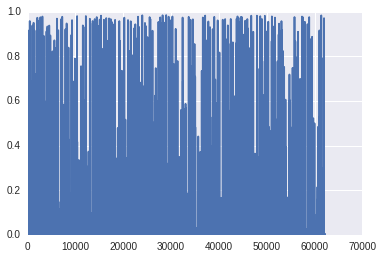

In [95]:
%matplotlib inline
plt.plot(bt_result.values)
plt.show()

In [ ]:
Scorer.calc_score

In [71]:
# profit calc
# pc = Scorer.calc_profit(
#     bt_result,
#     model_params['symbol'],
#     model_params['timeframe'],
#     bt_is_buy,
#     bt_loss_cut,
#     bt_profit_take,
#     bt_threshold)
# trades, total_gain, num_win, num_lose, max_drawdown = pc

In [72]:
# list up args as meta info
# meta = dict(args._get_kwargs())
# tmp = meta.pop('meta')
# meta.update(tmp)

# submit to algo_ci
# meta.pop('dataset')
# meta['model_params'].pop('features')
# from algoci import AlgoCI
# aci = AlgoCI()
# aci.put(
#     training_id=tlog.training_id,
#     loss=tlog.last_loss,
#     # backtesting results
#     bt_total_gain=total_gain,
#     bt_num_win=num_win,
#     bt_num_lose=num_lose,
#     bt_max_drawdown=max_drawdown,
#     # all args
#     **meta
# )

# # print out the training id
# print("training_id:{} iter:{}".format(tlog.training_id, tlog.last_iter))
# print("https://demo.capitalico.co/admin/dots/{}@{}".format(tlog.training_id, tlog.last_iter + 1))
# print("https://demo.capitalico.co/admin/loss/{}@{}".format(tlog.training_id, tlog.last_iter + 1))

# cleanup
trainer.shutdown()

In [87]:
model_params["config"]

{u'align': 200,
 u'basemodel': u'pb_v01_u250',
 u'batch_size': 260,
 u'dropout_ratio': 0.5,
 u'iters': 600,
 u'n_lstm': 4,
 u'n_units': 250,
 u'random_seed': 151,
 u'use_sigmoid': True}

In [90]:
from drivers.chainer.trainer import Trainer
import json
from utils import parse_json
from nb_utils import compare

def status_hook(i, l, seed, t):
    if i % 10 == 0:
        print('[{0}] Loss = {1}'.format(i, l))
    if (i + 1) % 100 == 0:
        t.rnn.model.to_cpu()
        compare.set_model_to_cache(t.rnn, '{0}_{1}.{2}'.format('${NAME}', i + 1, seed))
        with t.rnn.handler.device:
            t.rnn.model.to_gpu()

def logging_hook(i, train_dots, test_dots, train_loss, test_loss, model, seed):
    with open('{0}_{1}.{2}.pkl'.format('${NAME}', i + 1, seed), "w") as fp:
        fp.write(json.dumps({
            'train_dots': train_dots,
            'test_dots': test_dots,
            'train_loss': train_loss,
            'test_loss': test_loss,
        }))

def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

dataset = parse_json(load_json('/project/exp/list.json'))

mp = load_json("/project/exp/list_mp.json")
# for seed in [150, 151, 152]:
seed = 151

mp['config']['random_seed'] = seed
trainer = Trainer(mp, dataset, gpu_id=2)
callback = lambda i, l, s=seed, t=trainer: status_hook(i, l, s, t)
trainer.run(status_hook=callback)

[0] Loss = 3.85031359536e-05
[10] Loss = 5.26265095878e-06
[20] Loss = 5.41362592152e-06
[30] Loss = 5.04082343081e-06
[40] Loss = 4.82494359488e-06
[50] Loss = 5.10265899229e-06
[60] Loss = 4.75882141145e-06
[70] Loss = 4.69616546736e-06
[80] Loss = 4.39059046599e-06
[90] Loss = 4.25043047129e-06
[100] Loss = 4.36495424627e-06
[110] Loss = 4.47719208487e-06
[120] Loss = 3.75773847758e-06
[130] Loss = 4.24015260005e-06
[140] Loss = 3.99466857805e-06
[150] Loss = 3.53168196731e-06
[160] Loss = 3.43656801915e-06
[170] Loss = 2.6765450999e-06
[180] Loss = 3.73029512363e-06
[190] Loss = 2.39670194767e-06
[200] Loss = 3.44151520467e-06
[210] Loss = 2.05702129956e-06
[220] Loss = 2.17938652405e-06
[230] Loss = 2.13778018951e-06
[240] Loss = 2.33003317e-06
[250] Loss = 1.41042962179e-06
[260] Loss = 1.37795557033e-06
[270] Loss = 1.25214973321e-06
[280] Loss = 1.18918594096e-06
[290] Loss = 8.51764210633e-07
[300] Loss = 1.41947757412e-06
[310] Loss = 7.25405229317e-07
[320] Loss = 6.30196634

KeyboardInterrupt: 

In [91]:
trainer.rnn.save("test_1337")

---

---

---

In [ ]:
# dummy_scores_debug = pd.DataFrame({"confidence":[0.7,0.7,0.7]})
# dummy_scores_debug

In [125]:
backtest = Backtest("EURUSD",scores=bt_result)
ratio = Ratio(3,1) #profit_take : loss_cut = a : b
optimizer = Optimizer(backtest,ratio,"long",threshold=0.95) # side: "long" or "short", 

In [126]:
#%%time
o = optimizer.optimize(timeframe='5Min')

In [127]:
print(o.profit_take,o.loss_cut)
print(o.account.balance)

15 5
-47.4999999999


In [87]:
# current best algo ID: 1,088
# 20160310-174703_slk80-4-app-2-www_dc399006
# junya's basemodel: 20160308-143737_slk80-0-jnory-0-jnory_ac2cf197
# path_fmt = TrainLogger.path_fmt

# TrainLogger.path_fmt = 'trading/basemodel/logging/{}'
# obj = TrainLogger.load(tid, itr) # key, 6500

In [97]:
from ml import trainlogging

In [102]:
trainlogging.TrainLogger.load("20160311-162817_slk80-1-app-0-www_219a613d") #,6500)

KeyError: '20160311-162817_slk80-1-app-0-www_219a613d'

In [27]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
from nb_utils import basemodel
from drivers.chainer.trainer import Trainer
from utils import parse_json
import time
import copy
import json

In [36]:
# bucket_name = 'exp.alpacadb.com'
# path_fmt = 'trading/training/{}'
import os
import h5py
from ml.trainlogging import TrainLogger

def fetch(tid, itr, out):
    path_fmt = TrainLogger.path_fmt

#    TrainLogger.path_fmt = 'trading/hdf5/prod/{}' # 'trading/basemodel/logging/{}'
    TrainLogger.path_fmt = 'trading/basemodel/logging/{}'
    obj = TrainLogger.load(tid, itr)
    mstr = obj.get("h5model")

    with open(out + ".tmp", "wb") as fp:
        fp.write(mstr)

    log = h5py.File(out + ".tmp")
    h5 = h5py.File(out, "w")
    log["capitalico"].copy("/capitalico", h5)
    log["chainer"].copy("/chainer", h5)
    h5.close()
    os.unlink(out + ".tmp")

    TrainLogger.path_fmt = path_fmt

In [39]:
# 20160311-162817_slk80-1-app-0-www_219a613d
# 20160310-174703_slk80-4-app-2-www_dc399006
fetch("20160310-174703_slk80-4-app-2-www_dc399006", 6500, "/jupyter/data/pretrain.h5")


KeyError: '20160310-174703_slk80-4-app-2-www_dc399006@6500'

In [35]:
basemodel.fetch("20160311-162817_slk80-1-app-0-www_219a613d", 6500, "/jupyter/data/test.h5")
#fetch("20160310-174703_slk80-4-app-2-www_dc399006", 6500, "/jupyter/data/test.h5")


KeyError: '20160311-162817_slk80-1-app-0-www_219a613d@6500'